## Lung Cancer Classification

In [23]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix


import cv2
import os
import gc

In [24]:
path = "lung_colon_image_set/lung_image_sets"
classes = os.listdir(path)
print(classes)

['lung_aca', 'lung_n', 'lung_scc']


Explore the images for each class

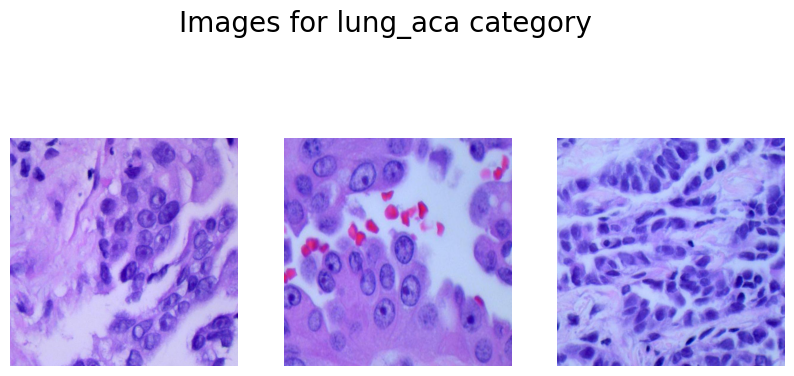

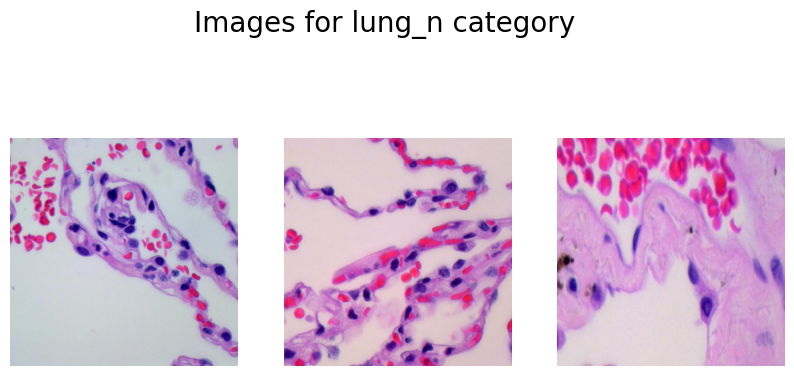

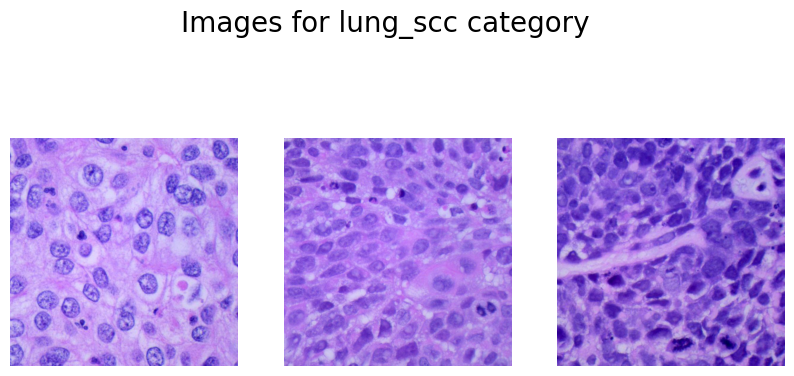

In [25]:
for c in classes:
    image_dir = f"{path}/{c}"
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    fig.suptitle(f"Images for {c} category", fontsize=20)

    # Display 3 random images from each class
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{c}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

Prepare the data for training

In [26]:
# Hyperparamters
IMG_SIZE = 256
BATCH_SIZE = 64
SPLIT = 0.3

In [27]:
X = []
Y = []

for i, cat in enumerate(classes):
    print(i, cat)
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images[:750]:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

0 lung_aca
1 lung_n
2 lung_scc


In [28]:
print('Shape of training data: ', X.shape)
print('Shape of test data: ', one_hot_encoded_Y.shape)

Shape of training data:  (2250, 256, 256, 3)
Shape of test data:  (2250, 3)


In [29]:
# Split the datasets into train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=42)

print("X Training set: ", train_X.shape)
print("X Test set: ", test_X.shape)
print("Y Training set: ", train_Y.shape)
print("Y Test set: ", test_Y.shape)

X Training set:  (1575, 256, 256, 3)
X Test set:  (675, 256, 256, 3)
Y Training set:  (1575, 3)
Y Test set:  (675, 3)


Build the CNN model

CNN Model Architecure

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def build_model(lr):
    # Input layer
    input_layer = Input(shape=train_X.shape[1:])

    # Hidden Layers
    x = Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same")(input_layer)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)


    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    # Output Layer
    output_layer = Dense(3, activation="softmax")(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(0.01)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,995,331 (38.13 MB)

 Trainable params: 9,993,027 (38.12 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [31]:
def train_model(epochs=50, batch_size=32):
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

    history = model.fit(
        train_X, 
        train_Y, 
        epochs=epochs,
        batch_size=batch_size, 
        validation_data=(test_X, test_Y),
        callbacks=[early_stop, reduce_lr]
    )
    return history

In [32]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
learning_rates = [0.01, 0.001, 0.0001]
pred_values = []
for lr in learning_rates:
    model = build_model(lr)
    history = train_model()
    
    pred = model.predict(test_X)
    pred_values.append([pred, lr]) 

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 891ms/step - accuracy: 0.5692 - loss: 1.2375 - val_accuracy: 0.5363 - val_loss: 130.6408 - learning_rate: 0.0100
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8634 - loss: 0.3230 - val_accuracy: 0.3719 - val_loss: 24.1217 - learning_rate: 0.0100
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 939ms/step - accuracy: 0.8932 - loss: 0.2707 - val_accuracy: 0.3126 - val_loss: 5.2360 - learning_rate: 0.0100
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 886ms/step - accuracy: 0.9081 - loss: 0.2315 - val_accuracy: 0.3022 - val_loss: 9.6024 - learning_rate: 0.0100
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 858ms/step - accuracy: 0.8929 - loss: 0.2820 - val_accuracy: 0.5452 - val_loss: 1.2335 - learning_rate: 0.0100
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 867ms/step - accuracy: 0.9052 - loss: 0.2498 - val_accuracy: 0.4726 - val_loss: 3.8202 - learning_rate: 0.0100
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9303 - loss: 0.196

Confusion Matrix for 0.01: [[234   9   0]
 [ 72 127   0]
 [226   0   7]]
              precision    recall  f1-score   support

    lung_aca       0.44      0.96      0.60       243
      lung_n       0.93      0.64      0.76       199
    lung_scc       1.00      0.03      0.06       233

    accuracy                           0.55       675
   macro avg       0.79      0.54      0.47       675
weighted avg       0.78      0.55      0.46       675



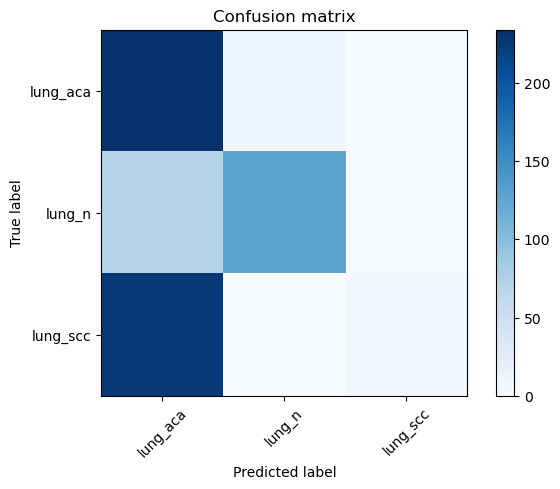

Confusion Matrix for 0.001: [[210   1  32]
 [  4 195   0]
 [ 11   0 222]]
              precision    recall  f1-score   support

    lung_aca       0.93      0.86      0.90       243
      lung_n       0.99      0.98      0.99       199
    lung_scc       0.87      0.95      0.91       233

    accuracy                           0.93       675
   macro avg       0.93      0.93      0.93       675
weighted avg       0.93      0.93      0.93       675



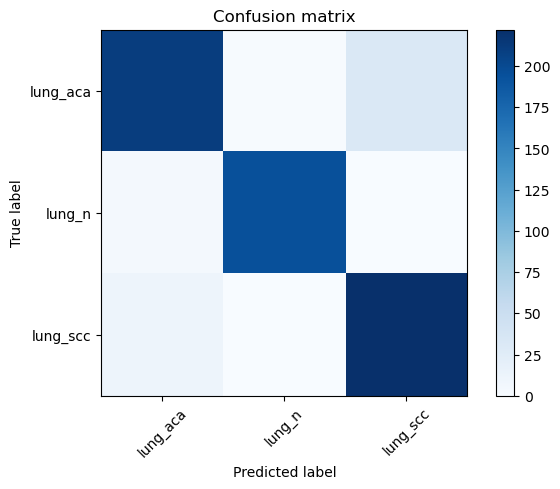

Confusion Matrix for 0.0001: [[225   2  16]
 [  3 196   0]
 [ 10   0 223]]
              precision    recall  f1-score   support

    lung_aca       0.95      0.93      0.94       243
      lung_n       0.99      0.98      0.99       199
    lung_scc       0.93      0.96      0.94       233

    accuracy                           0.95       675
   macro avg       0.96      0.96      0.96       675
weighted avg       0.95      0.95      0.95       675



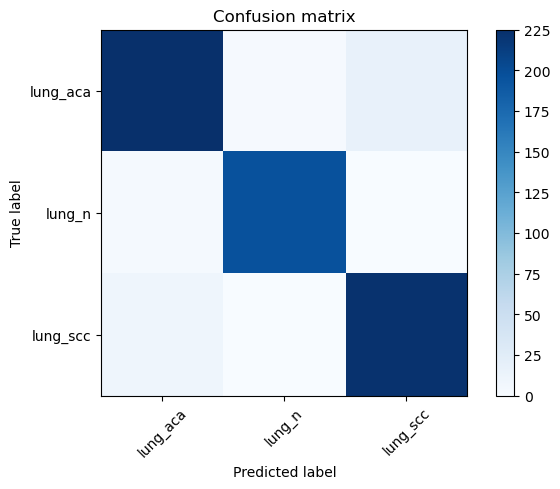

In [35]:
for x in pred_values:
    pred, lr = x[0], x[1]
    
    pred_classes = np.argmax(pred, axis=1)
    true_classes = np.argmax(test_Y, axis=1)

    cm = confusion_matrix(true_classes, pred_classes)

    print(f'Confusion Matrix for {lr}: {cm}')
    print(metrics.classification_report(true_classes, pred_classes, target_names=classes))
    plt.figure()
    plot_confusion_matrix(cm, classes)
    plt.show()